# ABS Detailed Labour Force 6291

## Python set-up

In [1]:
# system imports
from functools import cache

# analytic imports
import matplotlib.pyplot as plt
import pandas as pd
import readabs as ra
from readabs import metacol as mc

# local imports
from abs_helper import get_abs_data
from abs_summary_plot import plot_summary
from plotting import line_plot, finalise_plot

# pandas display settings
pd.options.display.max_rows = 99999
pd.options.display.max_columns = 999

# show charts within this notebook
SHOW = True

## Get data from ABS

In [2]:
# this was choking when I tried to get the monthly and quarterly in one go.
# Download still takes around half a minute.
abs_monthly, monthly_meta, source, RECENT = get_abs_data(
    "6291.0.55.001", single_zip_only="p6291_all_monthly_spreadsheets"
)
abs_qtrly, qtrly_meta, source, RECENT_DATE = get_abs_data(
    "6291.0.55.001", single_zip_only="p6291_all_quarterly_spreadheets"
)
plot_times = None, RECENT
plot_tags = "", "-recent"

## Plot

### Monthly by Age

recalibrate(): Units not appropriately calibrated: Percent


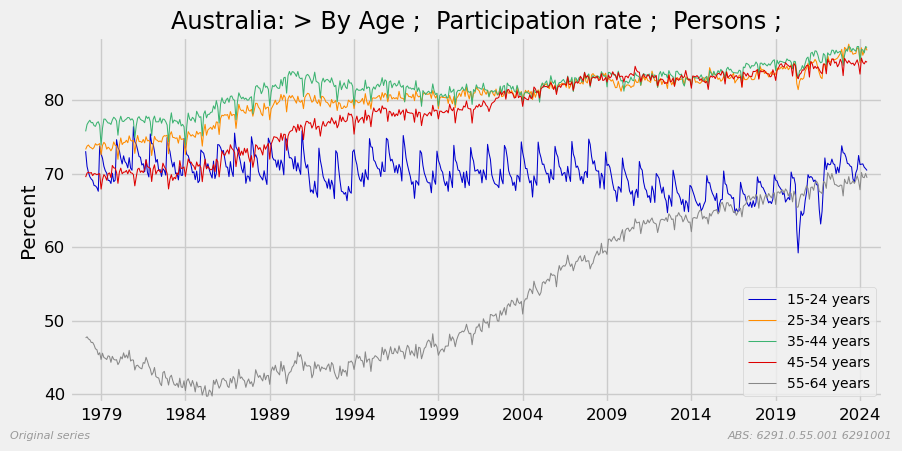

recalibrate(): Units not appropriately calibrated: Percent


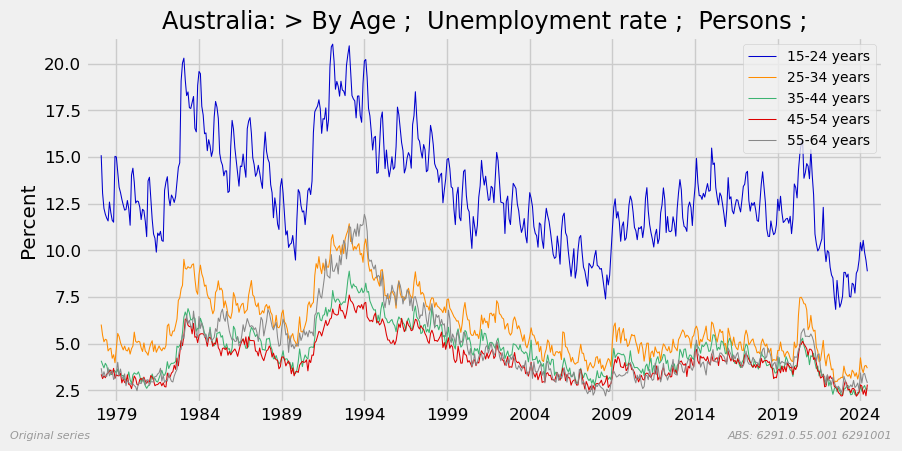

In [3]:
def monthly_by_age() -> None:
    """Produce monthly by age charts."""

    table = "6291001"
    data = abs_monthly[table]
    series_type = "Original"

    ages = [
        "15-24 years",
        "25-34 years",
        "35-44 years",
        "45-54 years",
        "55-64 years",
    ]

    token = "By Age"
    plots = [
        f"> {token} ;  Participation rate ;  Persons ;",
        f"> {token} ;  Unemployment rate ;  Persons ;",
    ]

    for plot in plots:
        combined = {}
        for age in ages:
            plot_desc = plot.replace(token, age)
            search = {
                plot_desc: mc.did,
                series_type: mc.stype,
                table: mc.table,
            }
            _table, ident, units = ra.find_abs_id(monthly_meta, search)
            combined[age] = data[ident]
        combined_df, units = ra.recalibrate(pd.DataFrame(combined), units)

        title = f"Australia: {plot}"
        line_plot(
            combined_df,
            title=title,
            ylabel=units,
            rfooter=f"{source} {table}",
            lfooter=f"{series_type.capitalize()} series",
            show=SHOW,
        )


monthly_by_age()

### Quarterly by sector

In [4]:
@cache
def get_sector() -> tuple[pd.DataFrame, pd.DataFrame]:
    """Get sector data."""

    table = "6291004"
    if table not in abs_qtrly:
        return pd.DataFrame(), pd.DataFrame()

    data = abs_qtrly[table]
    series_type = "Seasonally Adjusted"
    m = qtrly_meta
    selection = m[(m["Series Type"] == series_type) & (m["Table"] == table)]
    labels = selection[mc.did].str.split(" ; ").str[0]
    series_ids = selection.loc[labels.index, mc.id]
    sectors = data[series_ids]
    return sectors, selection

Overriding x0: True


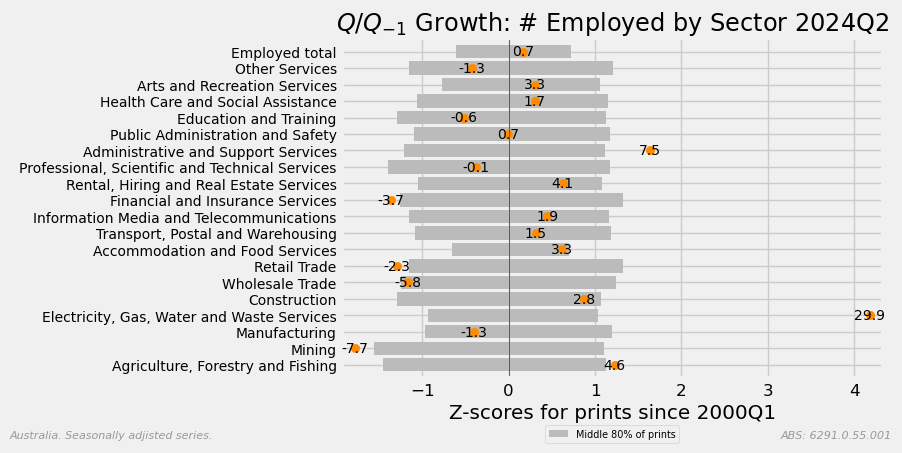

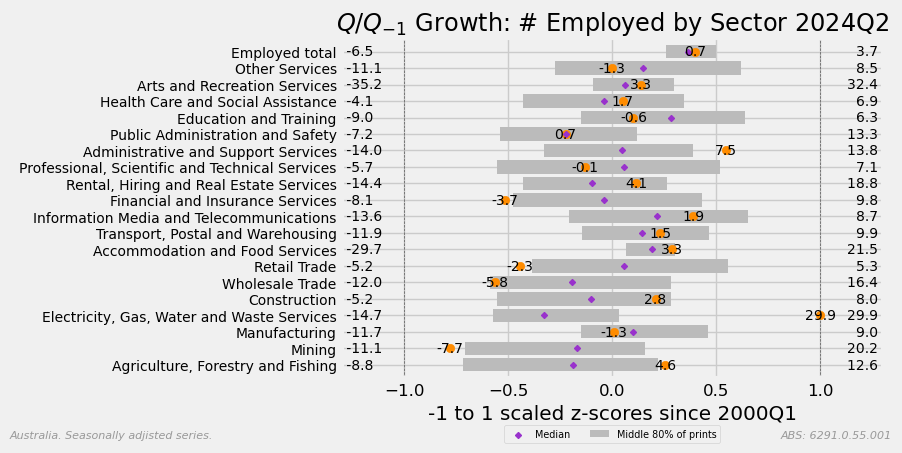

Overriding x0: True


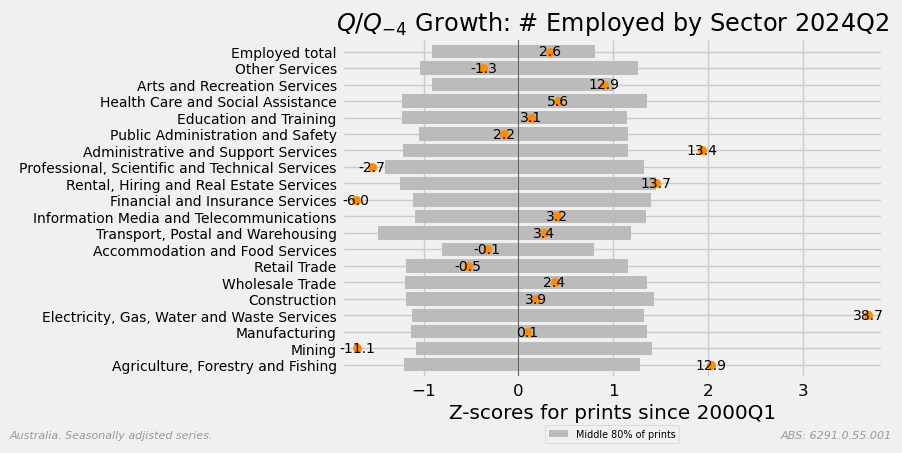

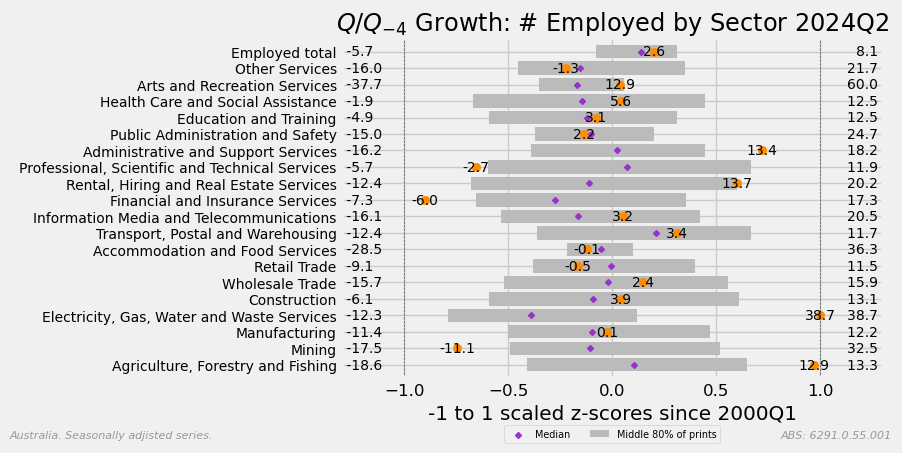

In [14]:
def summary_growth() -> None:
    """Produce quarterly sector growth charts."""

    sectors, selection = get_sector()
    if sectors.empty:
        return

    for period, title in zip([1, 4], ["$Q/Q_{-1}$", "$Q/Q_{-4}$"]):
        required = {
            x.split(" ;")[0]: (y, period)
            for x, y in zip(selection[mc.did], selection[mc.id])
        }
        plot_summary(
            required,
            abs_qtrly,
            qtrly_meta,
            start="2000Q1",
            title=f"{title} Growth: # Employed by Sector {sectors.index[-1]}",
            rfooter=source,
            lfooter=f"Australia. Seasonally adjisted series. ",
            show=SHOW,
        )


summary_growth()

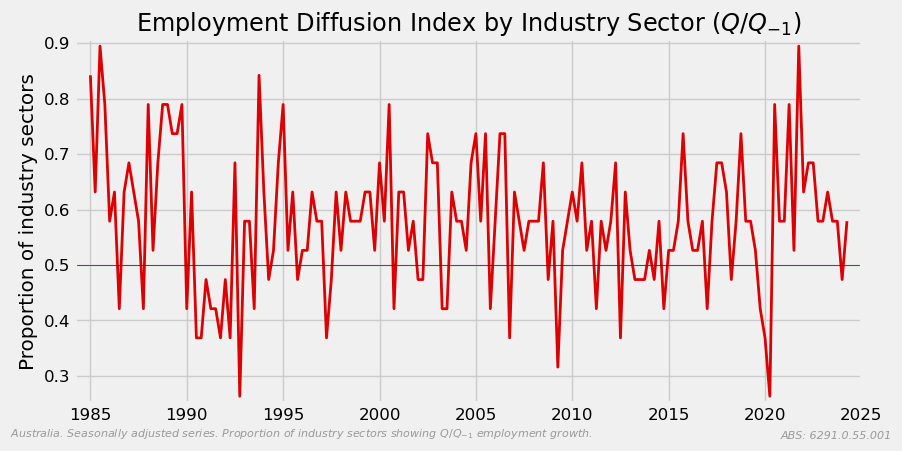

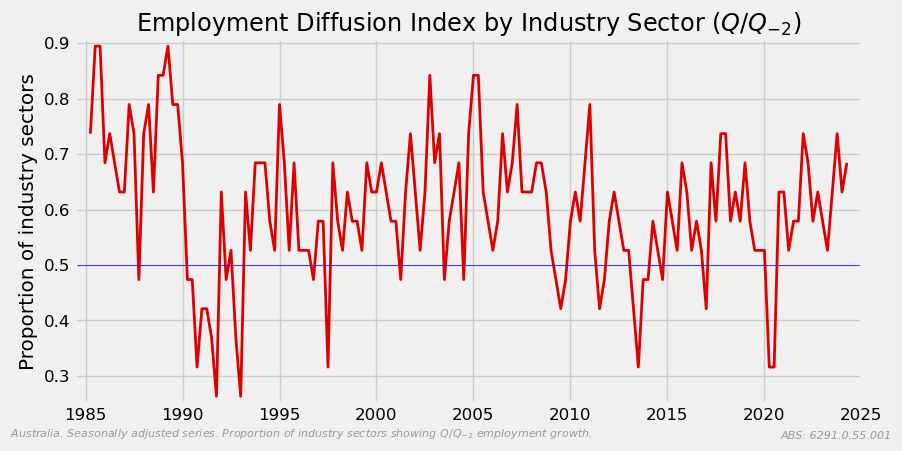

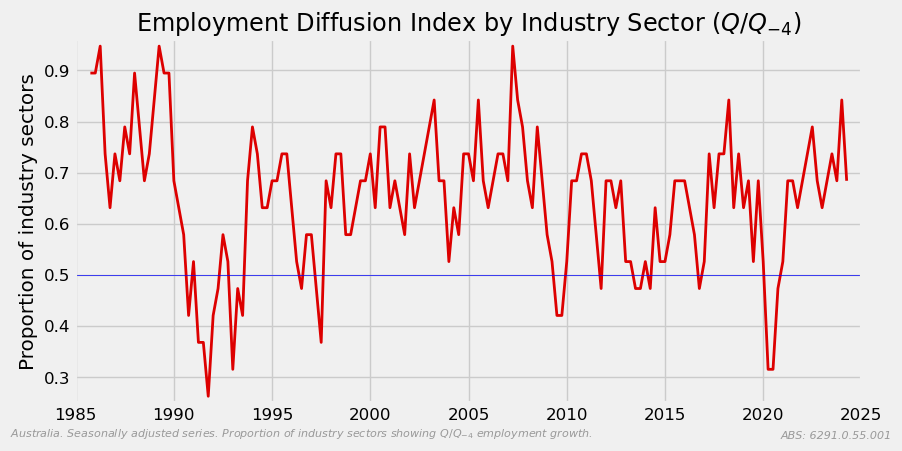

In [6]:
def diffusion() -> None:
    """Produce sectoral diffusion index timeseries chart."""

    sectors, selection = get_sector()
    if sectors.empty:
        return

    sectors.columns = pd.Index([x.split(" ;")[0] for x in selection[mc.did]])
    subset = [x for x in sectors.columns if "Employed" not in x]
    sectors = sectors[subset]
    for title, period in zip(["$Q/Q_{-1}$", "$Q/Q_{-2}$", "$Q/Q_{-4}$"], [1, 2, 4]):
        index = sectors.diff(period).dropna(how="all").map(
            lambda x: 1 if x > 0 else 0
        ).sum(axis=1) / sectors.notna().sum(axis=1)
        line_plot(
            index,
            title=f"Employment Diffusion Index by Industry Sector ({title})",
            ylabel="Proportion of industry sectors",
            rfooter=source,
            lfooter="Australia. Seasonally adjusted series. "
            + f"Proportion of industry sectors showing {title} employment growth. ",
            width=2,
            axhline={"y": 0.5, "lw": 0.5, "color": "b", "ls": "-"},
            show=SHOW,
        )


diffusion()

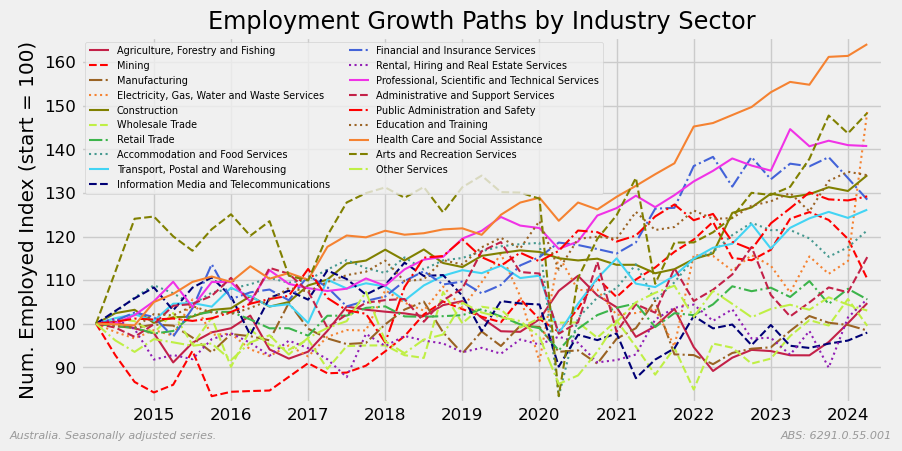

In [7]:
def growth_paths():

    sectors, selection = get_sector()
    if sectors.empty:
        return
    sectors.columns = pd.Index([x.split(" ;")[0] for x in selection[mc.did]])
    sectors = sectors[[x for x in sectors.columns if "Employed" not in x]]

    start = sectors.index[-1] - 40
    sectors = sectors.loc[lambda x: x.index >= start]
    sectors = sectors.div(sectors.iloc[0]) * 100
    line_plot(
        sectors,
        title="Employment Growth Paths by Industry Sector",
        ylabel="Num. Employed Index (start = 100)",
        rfooter=source,
        lfooter="Australia. Seasonally adjusted series. ",
        legend={"loc": "upper left", "ncol": 2, "fontsize": 7},
        width=1.5,
        style=["-", "--", "-.", ":"],
        show=SHOW,
    )


growth_paths()

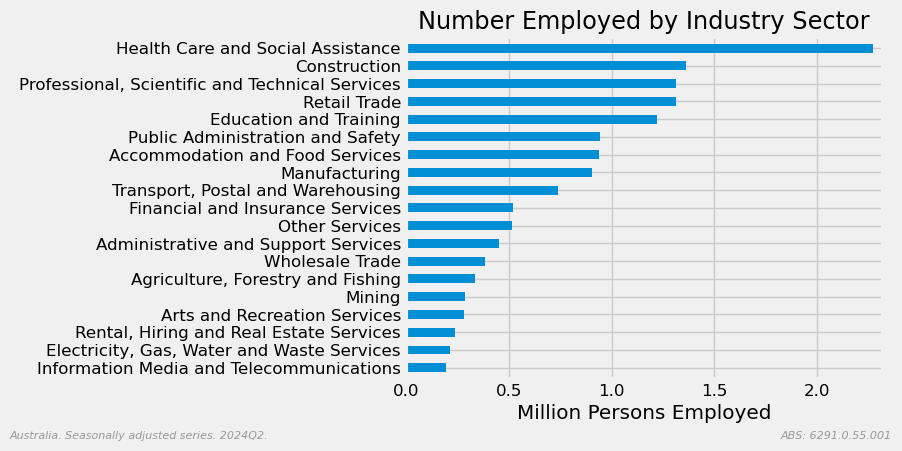

In [8]:
def number_employed():

    sectors, selection = get_sector()
    if sectors.empty:
        return
    sectors.columns = [x.split(" ;")[0] for x in selection[mc.did]]
    sectors = sectors[[x for x in sectors.columns if "Employed" not in x]]

    ax = sectors.iloc[-1].div(1000).sort_values().plot(kind="barh")
    finalise_plot(
        ax,
        title="Number Employed by Industry Sector",
        ylabel=None,
        xlabel="Million Persons Employed",
        rfooter=source,
        lfooter=f"Australia. Seasonally adjusted series. {sectors.index[-1]}. ",
        show=SHOW,
    )


number_employed()

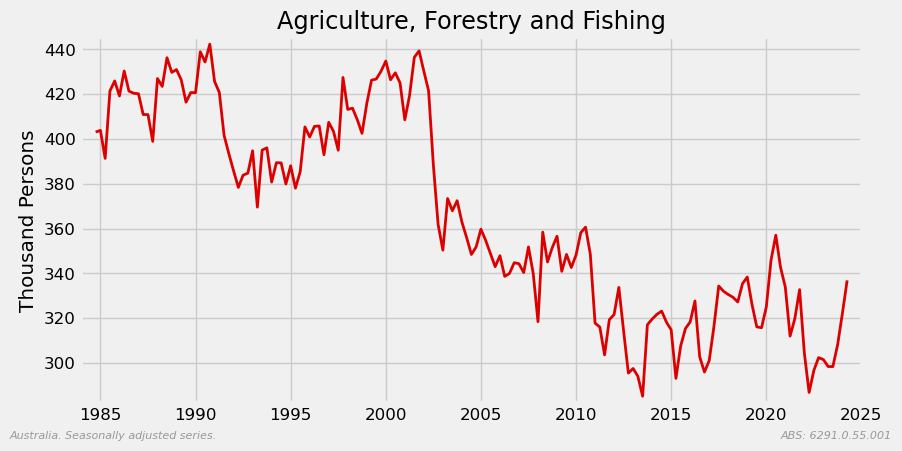

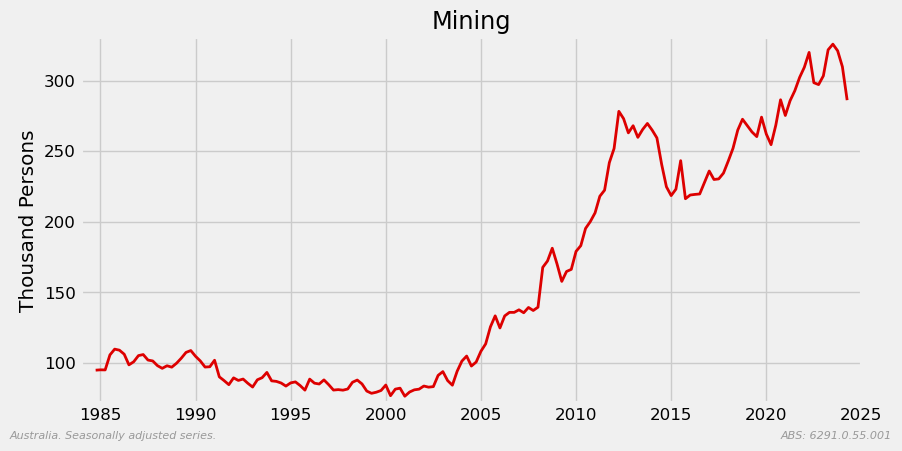

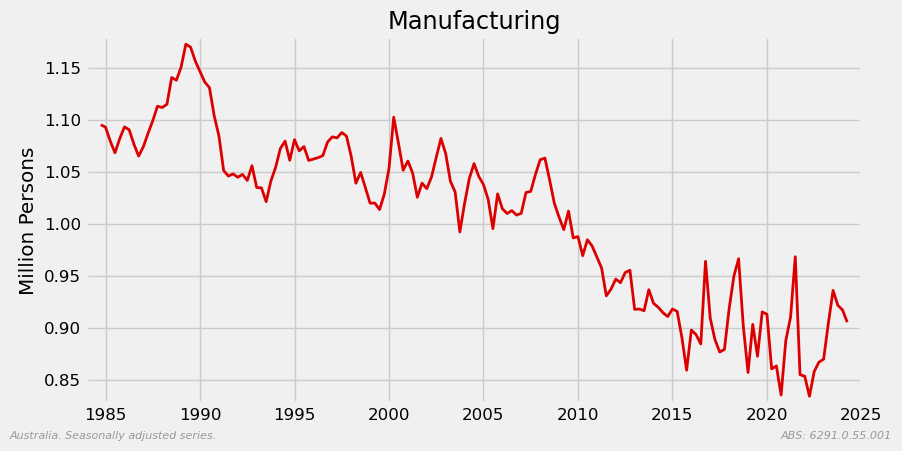

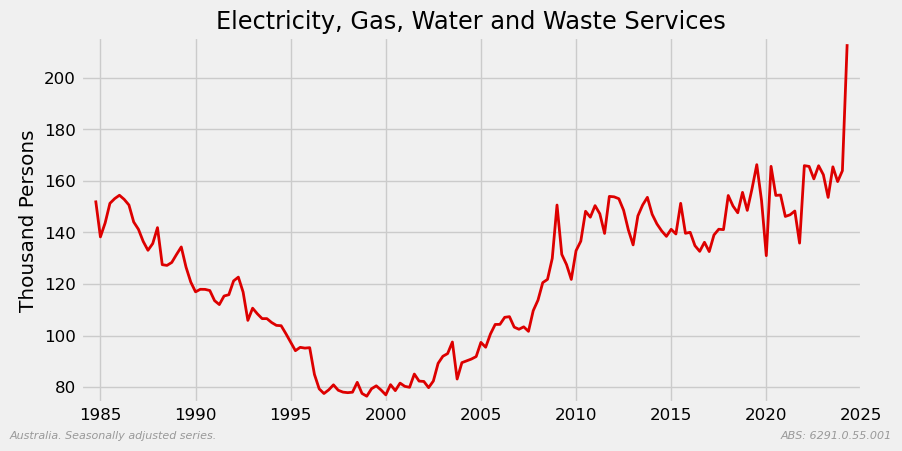

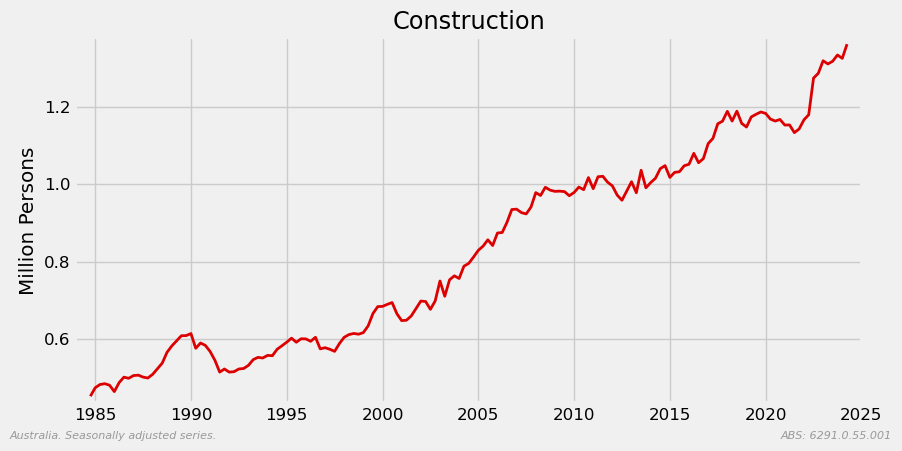

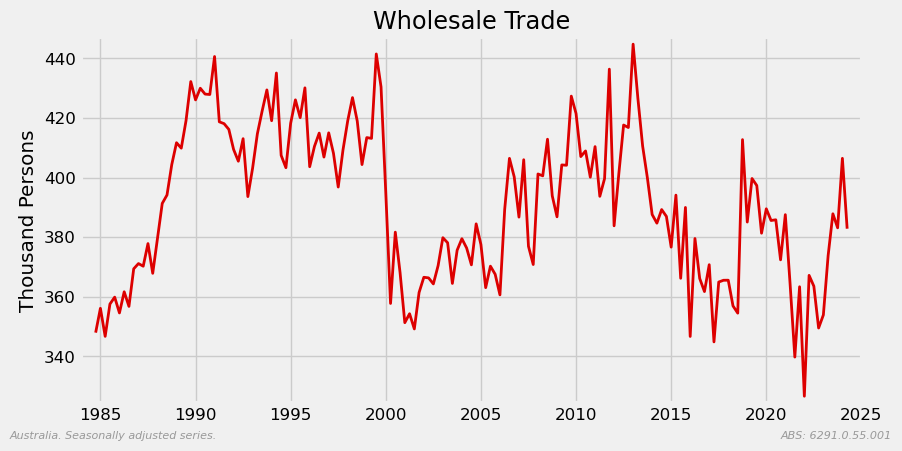

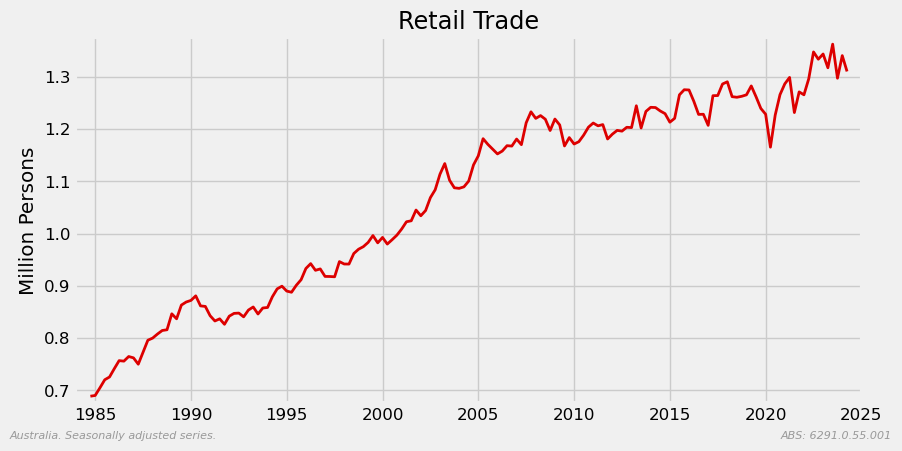

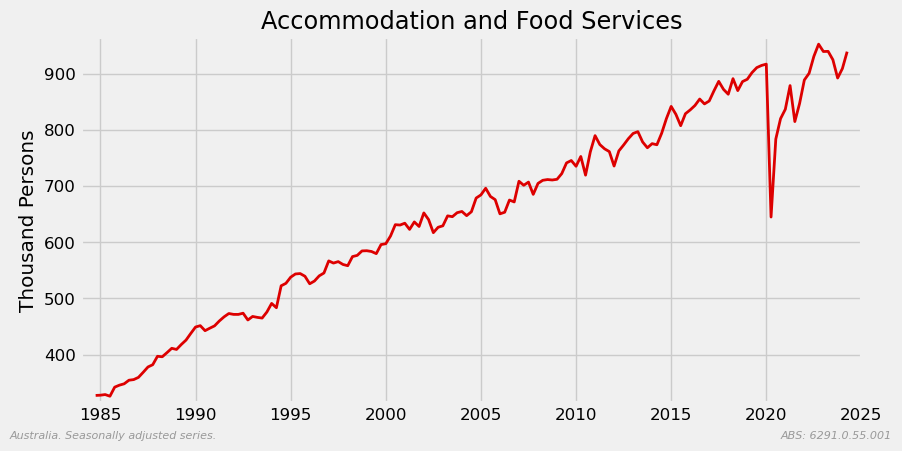

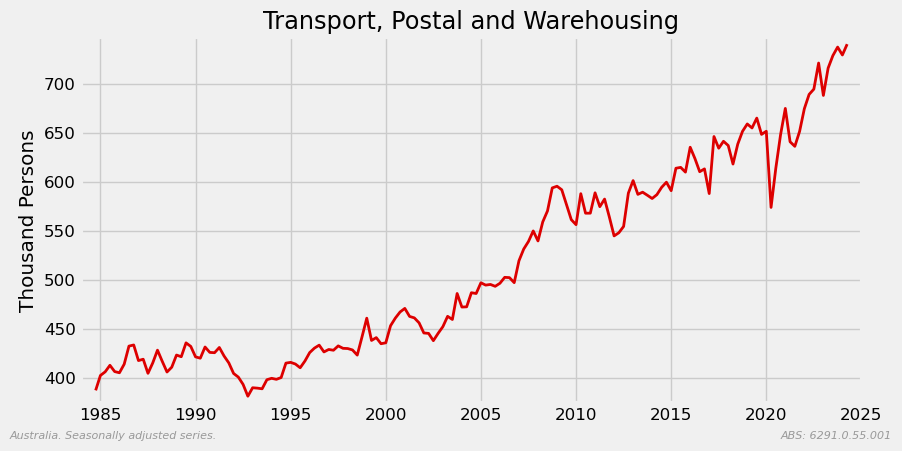

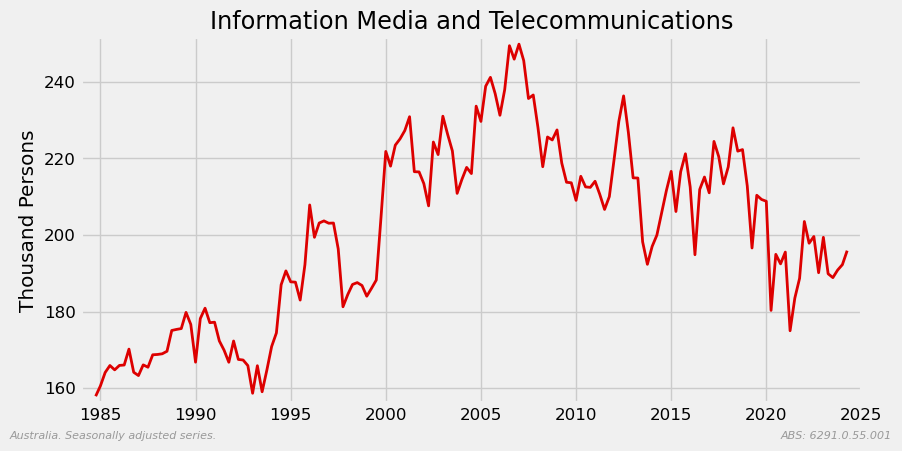

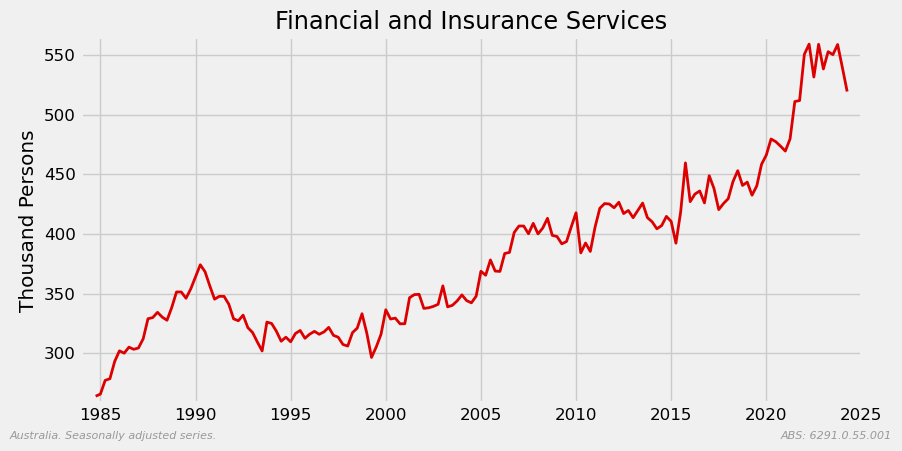

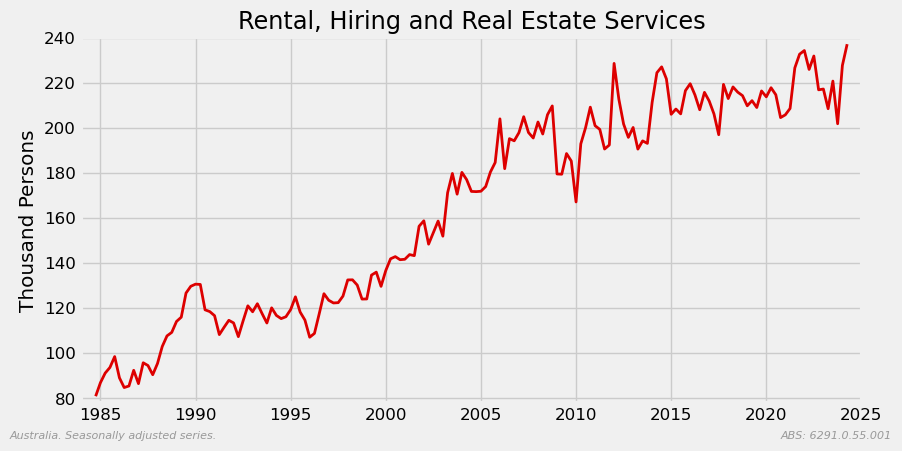

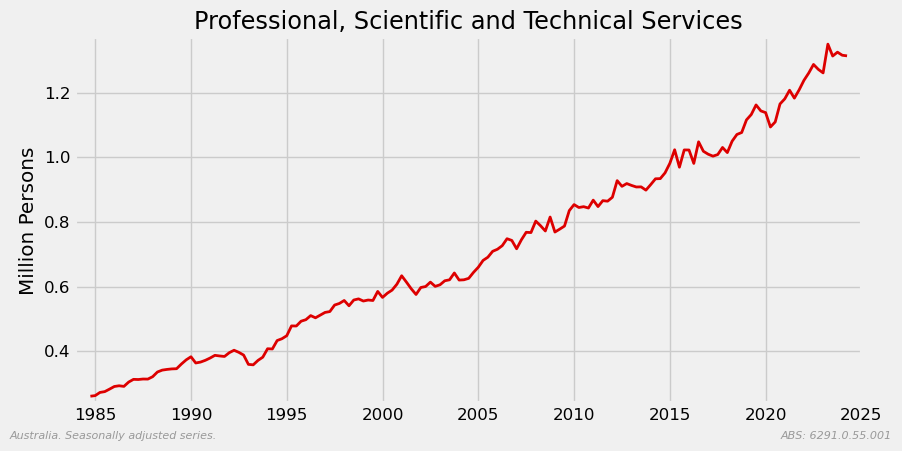

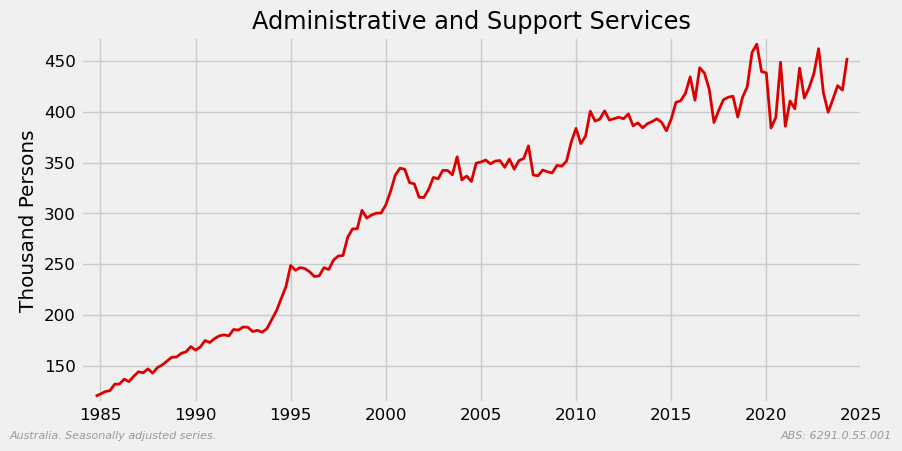

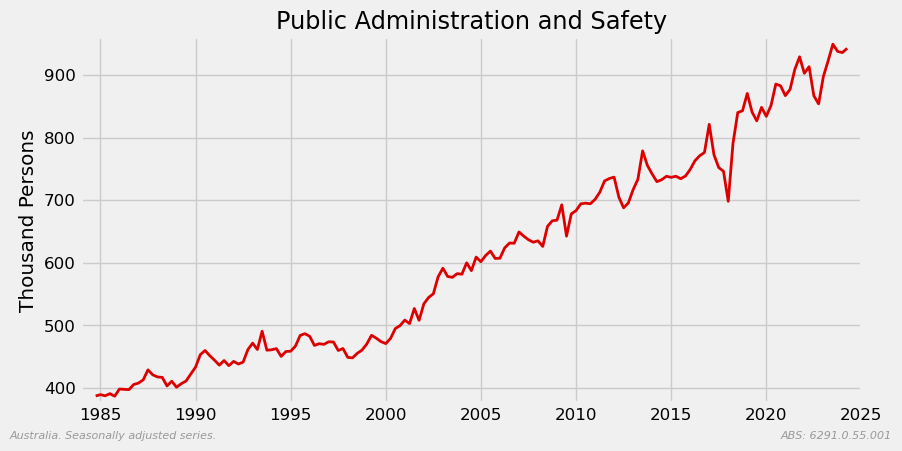

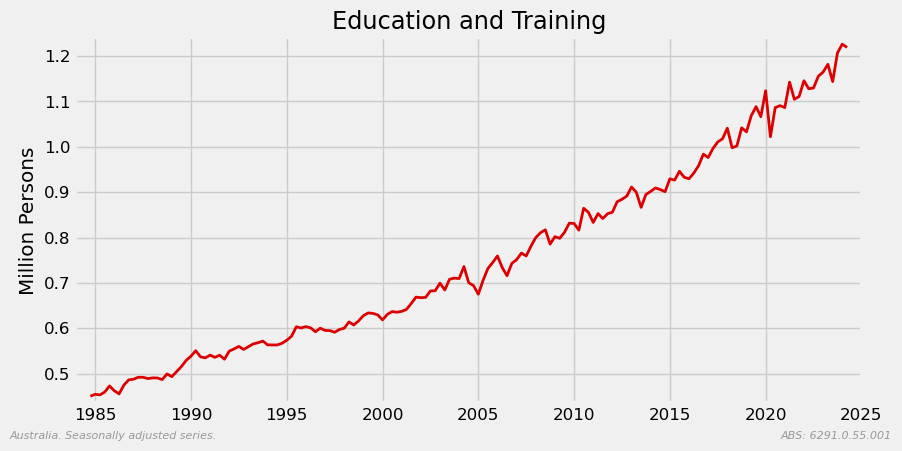

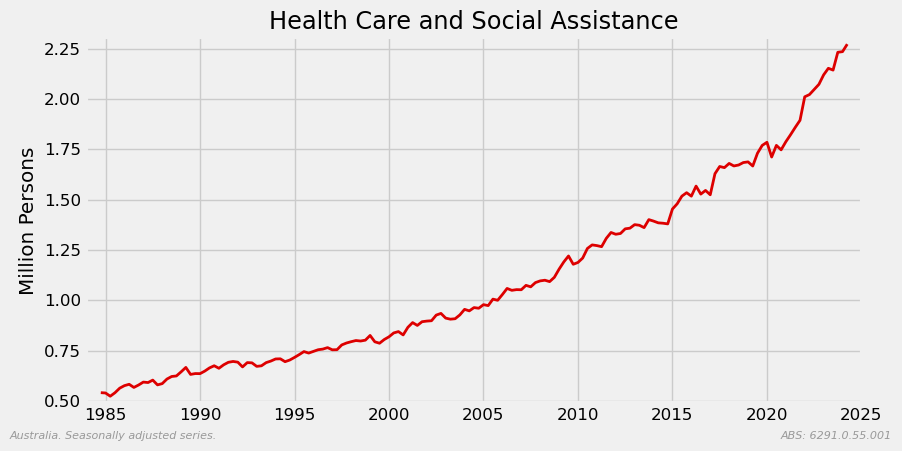

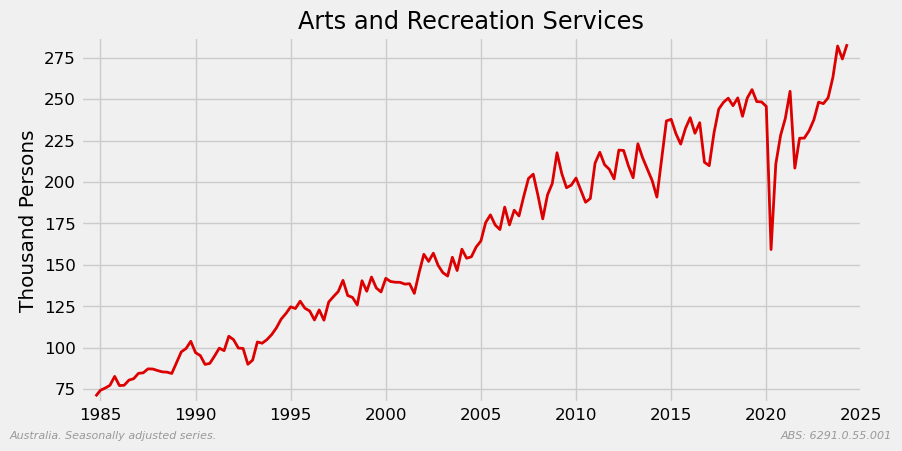

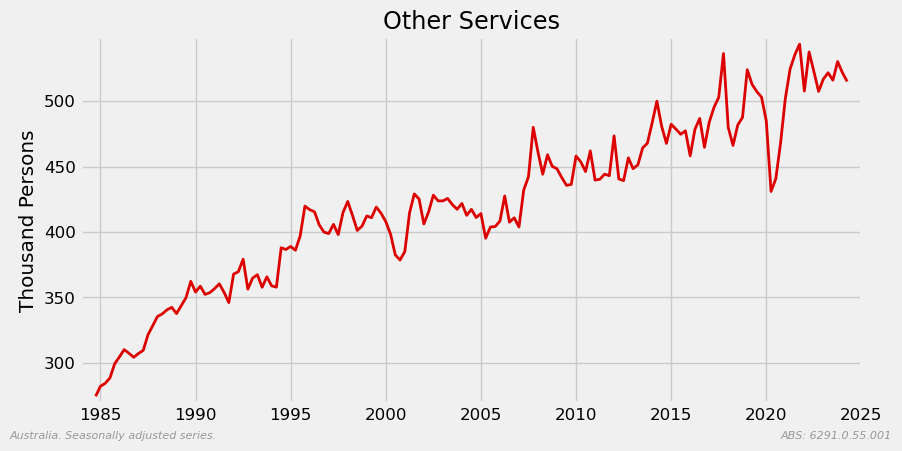

In [9]:
def quarterly_by_sector() -> None:
    """Produce quarterly by sector charts."""

    sectors, selection = get_sector()
    if sectors.empty:
        return
    sectors.columns = pd.Index([x.split(" ;")[0] for x in selection[mc.did]])
    sectors = sectors[[x for x in sectors.columns if "Employed" not in x]]

    # individual sector plots for number employed ...
    for col, series in sectors.items():
        series, units = ra.recalibrate(series, "Thousand Persons")
        line_plot(
            series,
            title=col,
            ylabel=units,
            width=2,
            rfooter=source,
            lfooter=f"Australia. Seasonally adjusted series. ",
            show=SHOW,
        )


quarterly_by_sector()

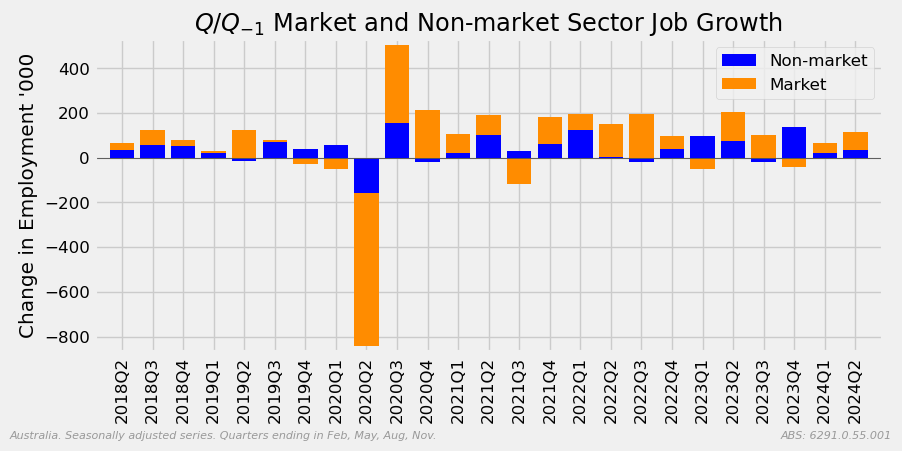

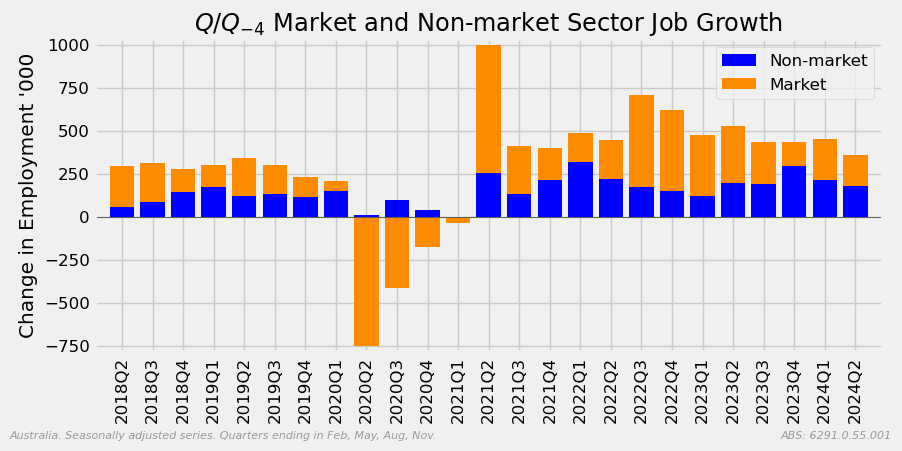

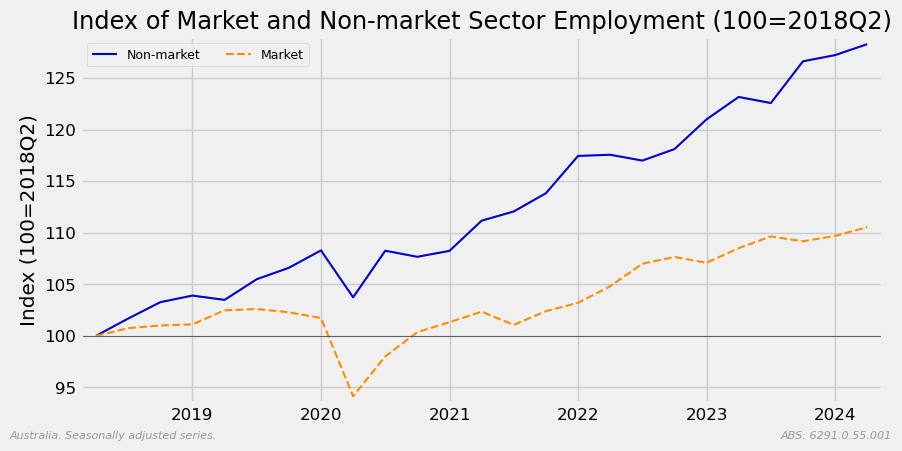

In [10]:
def job_growth_by_market_sector():

    abs_dict = abs_qtrly
    meta = qtrly_meta

    table = "6291004"
    data_table = abs_dict[table]
    series_type = "Seasonally Adjusted"
    selection = meta[(meta["Series Type"] == series_type) & (meta["Table"] == table)]
    labels = selection[mc.did].str.split(" ; ").str[0]
    series_ids = selection.loc[labels.index, mc.id]

    data = data_table.loc[:, series_ids[:-1]].rename(columns=labels)

    # growth by market sector ...
    non_market = [
        "Public Administration and Safety",
        "Education and Training",
        "Health Care and Social Assistance",
    ]

    for p, title in zip([1, 4], ["$Q/Q_{-1}$", "$Q/Q_{-4}$"]):
        nm_jobs = data[non_market].sum(axis=1)
        m_jobs = data.loc[:, ~data.columns.isin(non_market)].sum(axis=1)
        nm_growth = nm_jobs.diff(p).dropna()
        m_growth = m_jobs.diff(p).dropna()
        m_data = pd.DataFrame({"Non-market": nm_growth, "Market": m_growth})
        N = 25
        ax = m_data.iloc[-N:].plot.bar(
            stacked=True, width=0.8, color=["blue", "darkorange"]
        )

        finalise_plot(
            ax,
            title=f"{title} Market and Non-market Sector Job Growth",
            ylabel="Change in Employment '000",
            rfooter=source,
            lfooter=f"Australia. {series_type.capitalize()} series. "
            + "Quarters ending in Feb, May, Aug, Nov. ",
            y0=True,
            show=SHOW,
        )

    # growth paths over the past N years ...
    N = 25  # quarters
    nm_index = nm_jobs / nm_jobs.iloc[-N] * 100.0
    m_index = m_jobs / m_jobs.iloc[-N] * 100.0
    m_data = pd.DataFrame({"Non-market": nm_index, "Market": m_index})
    line_plot(
        m_data.iloc[-N:],
        title=f"Index of Market and Non-market Sector Employment (100={m_data.index[-N]})",
        ylabel=f"Index (100={m_data.index[-N]})",
        rfooter=source,
        lfooter=f"Australia. {series_type.capitalize()} series. ",
        legend={"loc": "upper left", "ncol": 2, "fontsize": 9},
        style=["-", "--", "-.", ":"],
        axhline={"y": 100, "color": "#555555", "linewidth": 0.66, "linestyle": "-"},
        width=1.5,
        show=SHOW,
    )


job_growth_by_market_sector()

### Monthly by duration of unemployment

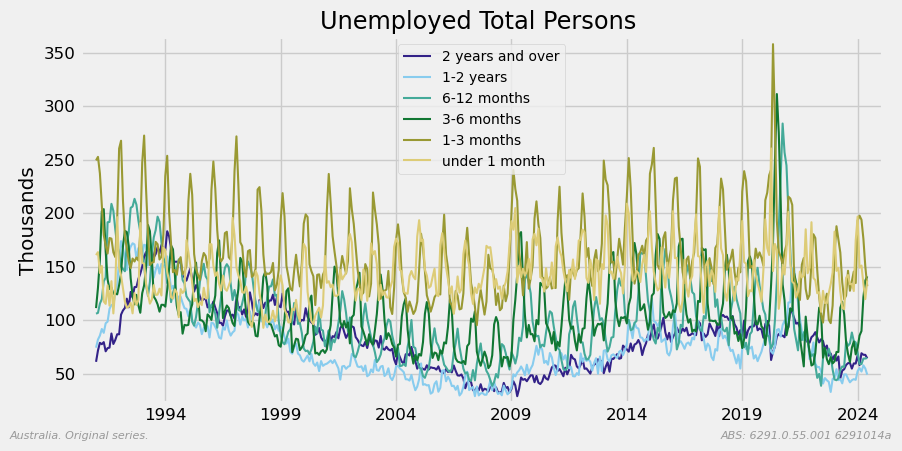

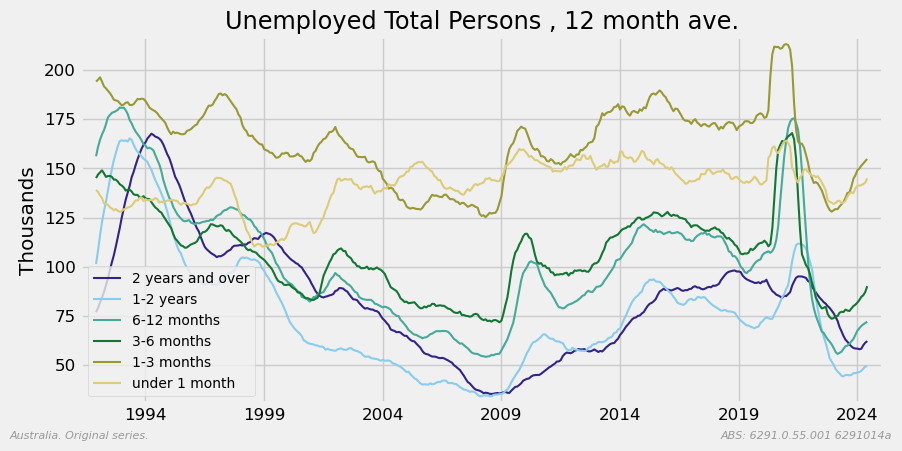

In [11]:
def monthly_by_ue_duration() -> None:
    """Produce monthly UE duration charts."""

    abs_dict = abs_monthly
    meta = monthly_meta

    table = "6291014a"
    df = abs_dict[table]
    series_type = "Original"

    cohorts = [
        "2 years and over",
        "1-2 years",
        "6-12 months",
        "3-6 months",
        "1-3 months",
        "under 1 month",
    ]

    categories = ["Unemployed total ;  Persons ;"]
    period = 12
    for category in categories:
        raw = pd.DataFrame()
        trend = pd.DataFrame()
        for cohort in cohorts:
            rows = meta[
                meta[mc.did].str.contains(category) & meta[mc.did].str.contains(cohort)
            ]
            assert len(rows) == 1
            select = rows["Series ID"].values[0]
            units = rows["Unit"].values[0]
            raw[cohort] = df[select]
            trend[cohort] = df[select].rolling(period).mean()

        title = (
            category.replace(" ; ", " ").replace(" ;", " ").replace("  ", " ").title()
        )
        lfooter = f"Australia. {series_type.capitalize()} series. "

        trend, u = ra.recalibrate(trend, units)
        raw, u = ra.recalibrate(raw, units)
        for data, t in zip([raw, trend], [title, f"{title}, {period} month ave."]):
            line_plot(
                data,
                title=t,
                ylabel=u,
                rfooter=f"{source} {table}",
                lfooter=lfooter,
                width=1.5,
                show=SHOW,
            )


monthly_by_ue_duration()

## Finished

In [12]:
# watermark
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Fri Aug 09 2024 12:37:17

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

readabs   : 0.0.17
pandas    : 2.2.2
matplotlib: 3.9.1

Watermark: 2.4.3



In [13]:
print("Finished")

Finished
